<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 13: Big Spatial Data</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>
</div>

This notebook was adapted from:
* [Tutorial on efficient GeoPandas](https://github.com/martinfleis/efficient-geopandas-workshop)
* [Tutorial on spatial indexes](https://github.com/gboeing/ppd599/blob/2017/19-Spatial-Analysis-and-Cartography/rtree-spatial-indexing.ipynb)
* [User Guide to Dask-GeoPandas](https://dask-geopandas.readthedocs.io/en/stable/guide.html)
* [Intro to Dask-GeoPandas](https://dask-geopandas.readthedocs.io/en/stable/guide/basic-intro.html)
* [Tutorial on H3](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb)
* [Spatial Thoughts' Tutorial on H3](https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/)

# Working with large geospatial data sets

In this notebook we will learn:
- how to utilize spatial indexes in GeoPandas
- tips and tricks for using GeoPandas efficiently
- how to work with Dask-GeoPandas
- using H3 to index and analyze data

## Spatial Indexes with GeoPandas

You can see the documentation for the spatial index (`sindex`) in GeoPandas [here](https://geopandas.org/en/stable/docs/reference/sindex.html).

In [1]:
import geopandas as gpd
from tqdm import tqdm
import contextily as cx

**First, let's load two geodataframes with a polygon and a point datasets:**

The polygons are the voting areas we've been working with before.

The point dataset represents all the trees in Denmark and come from [GeoDanmark](https://datafordeler.dk/dataoversigt/geodanmark-vektor/geodanmark-vektor-praedefineret-gml/).

The data were originally downloaded in a [GML](https://en.wikipedia.org/wiki/Geography_Markup_Language) format.
Reading the dataset into a GeoDataframe from GML can be very slow (~3 minutes on a mac with 16gb RAM).

In [2]:
%%time
# NOTE Only run this cell if you want to confirm that this indeed is slow
trees = gpd.read_file("data/trae.gml")

CPU times: user 2min 25s, sys: 32.7 s, total: 2min 58s
Wall time: 3min 10s


Instead, we can use the much faster file format [GeoParquet](https://geoparquet.org/) based on Apache Parquet (~10 seconds on the same laptop):

In [3]:
%%time
trees = gpd.read_parquet('data/trees.parquet')
trees = trees[['objectid','geometry']]
trees.head()

CPU times: user 7.41 s, sys: 4.94 s, total: 12.4 s
Wall time: 12.9 s


objectid                                      geometry
0  121680966620210914113041544  MULTIPOINT Z (712251.160 6186729.850 49.040)
1  121680966720210914113041544  MULTIPOINT Z (711110.060 6187458.770 53.490)
2     102531006420171025082936  MULTIPOINT Z (702211.290 6133996.690 16.400)
3     102531006520171025082936  MULTIPOINT Z (702212.950 6133992.680 16.350)
4     102531006620171025082936  MULTIPOINT Z (702210.770 6133991.750 16.450)

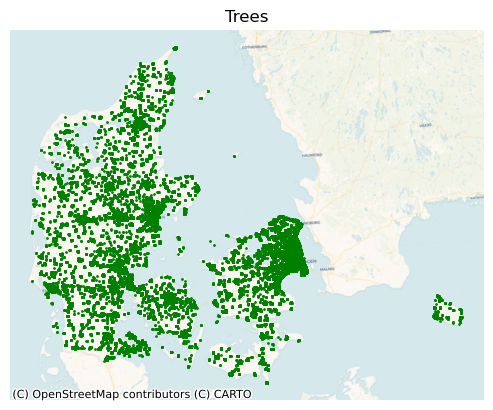

In [4]:
# The tree dataset is quite large, so we only plot a subset
ax = trees.sample(100_000).plot(color="green", markersize=1)
ax.set_title("Trees")
cx.add_basemap(ax=ax, crs=trees.crs, source=cx.providers.CartoDB.Voyager)
ax.set_axis_off()

In [2]:
areas = gpd.read_file("data/voting_areas.gpkg")

areas.head()

local_id                        voting_name municipal_id     area_name  \
0       17          Hammerum-Gjellerup Hall'n         0657      Hammerum   
1       15         Gullestrup Sport og Kultur         0657    Gullestrup   
2       08                Sdr. Felding Hallen         0657  Sdr. Felding   
3       27  Vildbjerg Sports- og Kulturcenter         0657     Vildbjerg   
4       08                             Længen         0210       Karlebo   

   ValgstedId                                           geometry  
0      657017  MULTIPOLYGON Z (((499898.900 6224849.820 0.000...  
1      657015  MULTIPOLYGON Z (((496037.860 6226101.190 0.000...  
2      657008  MULTIPOLYGON Z (((483026.180 6200592.380 0.000...  
3      657027  MULTIPOLYGON Z (((477917.280 6229128.160 0.000...  
4      210008  MULTIPOLYGON Z (((710547.580 6203125.960 0.000...

In [7]:
areas[areas.municipal_id=='0101']

local_id                         voting_name municipal_id  \
205        55                  Skolen i Sydhavnen         0101   
206        13                               Hal C         0101   
207        19                   Skolen ved Sundet         0101   
437        53                  Vesterbro Ny Skole         0101   
463        47                Sankt Annæ Gymnasium         0101   
550        50          Oehlenschlægersgades Skole         0101   
551        54                     Bavnehøj Hallen         0101   
552        10            Skolen på Islands Brygge         0101   
553        01                       Østerbrohuset         0101   
554        57                       Dyveke Skolen         0101   
555        56         Skolen på Strandboulevarden         0101   
556        16               Lergravsparkens Skole         0101   
739        33                      Rødkilde Skole         0101   
740        11                        Rådhushallen         0101   
741        14                       Nyboder Skole         0101   
1023       30               Grøndalsvængets Skole         0101   
1028       29                      Lundehusskolen         0101   
1032       34                      Bellahøj Skole         0101   
1036       25  Frederiksgård Skole (Hillerødgade)         0101   
1038       39                   Katrinedals Skole         0101   
1039       03                             Remisen         0101   
1042       05                  Nørre Fælled Skole         0101   
1056       27                      Tagensbo Skole         0101   
1057       40                    Kirkebjerg Skole         0101   
1065       52                Gasværksvejens Skole         0101   
1080       28                       Holbergskolen         0101   
1083       36                         Husum Skole         0101   
1090       51                     Ellebjerg Skole         0101   
1104       32                     Tingbjerg Skole         0101   
1120       35             EnergiCenter Voldparken         0101   
1139       12           Øster Farimagsgades Skole         0101   
1142       23                 Plejecentret Sølund         0101   
1149       41               Vanløsehallerne Hal 2         0101   
1163       07             Sundby Idrætspark Hal 3         0101   
1166       58                      Nørrebrohallen         0101   
1179       31                      Brønshøj Skole         0101   
1186       21                 Rådmandsgades Skole         0101   
1195       48               Vigerslev Allés Skole         0101   
1196       18                      Gerbrandskolen         0101   
1200       06                    Kildevældsskolen         0101   
1225       49               Tove Ditlevsens Skole         0101   
1230       20      Guldberg Skole (Sjællandsgade)         0101   
1233       43                         Prøvehallen         0101   
1243       09                       Ørestad Skole         0101   
1257       44                Kirsebærhavens Skole         0101   
1262       24                 Nørrebro Park Skole         0101   
1267       17     Skolen på Amagerbro (Sønderbro)         0101   
1277       02                    Strandvejsskolen         0101   
1280       22                      Korsgadehallen         0101   
1288       46                      Lykkebo Hallen         0101   
1313       42                        Ålholm Skole         0101   
1323       59                     Utterslev Skole         0101   
1338       08                 Amager Fælled Skole         0101   

              area_name  ValgstedId  \
205          9. Sydhavn      101055   
206              3. Syd      101013   
207              4. Øst      101019   
437             9. Vest      101053   
463           8. Sydøst      101047   
550             9. Nord      101050   
551             9. Midt      101054   
552             2. Vest      101010   
553         1. Østerbro      101001   
554              2. Øst      101057   
555        

<AxesSubplot: >

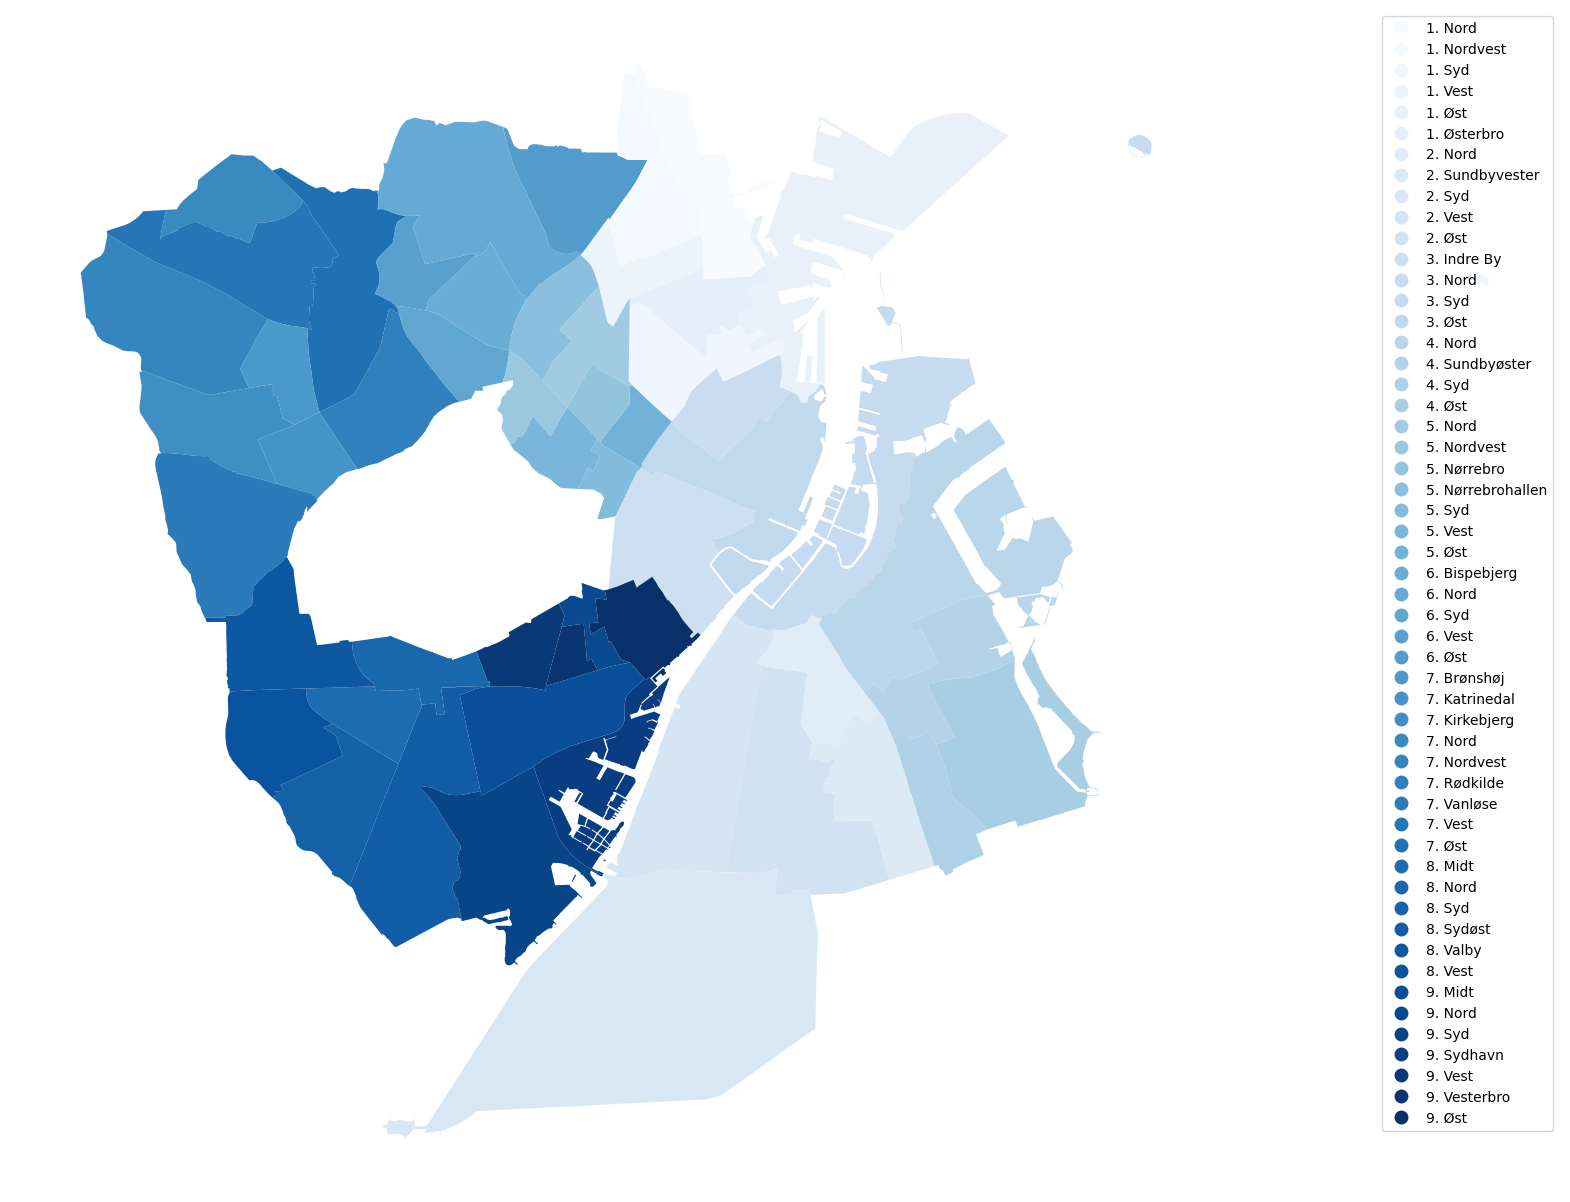

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()
areas[areas.municipal_id=='0101'].plot(ax=ax,categorical=True, column='area_name',cmap='Blues',legend=True)

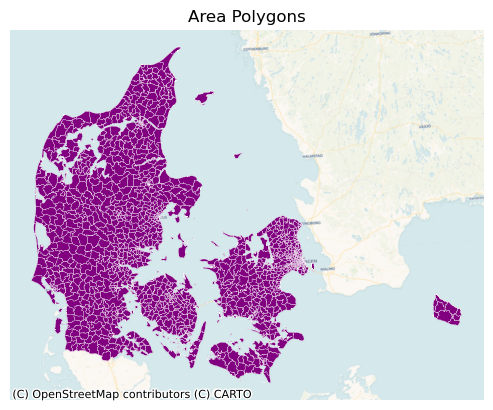

In [6]:
ax = areas.plot(color="purple", edgecolor='white', linewidth=0.2)
ax.set_title("Area Polygons")
cx.add_basemap(ax=ax, crs=areas.crs, source=cx.providers.CartoDB.Voyager)
ax.set_axis_off()

GeoPandas also supports the [feather](https://geopandas.org/en/latest/docs/user_guide/io.html#apache-parquet-and-feather-file-formats) file format:

In [7]:
trees2 = gpd.read_feather('data/trees.feather')

In [8]:
del trees2

Let's first check if our data have a spatial index:

In [9]:
areas.sindex

We can see here that is is an *R Tree Index* using [PyGEOS](https://pygeos.readthedocs.io/en/stable/strtree.html).

In [10]:
areas.sindex.is_empty

False

In [11]:
trees.sindex

In [12]:
trees.sindex.is_empty

False

Never versions of GeoPandas automatically creates a spatial index. For other libraries and programming languages, you might need to create it manually.

### Spatial intersection with spatial indexes

To illustrate the difference between using a spatial index and not, let's try to iterate* through the areas dataset and find for each polygon find the trees that intersect with it.

In the first version we first use a simple intersect query on the tree and area geometries:

**Using a for-loop is of course not an efficient way of writing code in general, but it is good for illustrating performance benefits:*

For this demonstration, we will just use a subset of the trees dataset:

In [13]:
trees_subset = trees[0:200000]

In [14]:
for i, specific_parcel in tqdm(areas.iterrows(), total=len(areas)):
    # run intersection for every building<->parcel pair
    is_intersection = trees_subset.geometry.intersects(specific_parcel.geometry)
    overlapping_buildings = trees_subset.loc[is_intersection]

100%|██████████| 1347/1347 [00:53<00:00, 25.27it/s]


In [15]:
for i, specific_parcel in tqdm(areas.iterrows(), total=len(areas)):
    # spatial_index.query() for every parcel
    possible_matches_index = list(trees_subset.sindex.query(specific_parcel.geometry))
    possible_matches = trees_subset.iloc[possible_matches_index]
    # run true intersection query only on possible matches
    actual_matches = possible_matches[possible_matches.intersects(specific_parcel.geometry)]

100%|██████████| 1347/1347 [00:45<00:00, 29.49it/s]


In the last step we *explicitly* used the spatial index of the trees dataset to:
* first find possible matches between the location of trees and our area data set.
* second, find exact intersections among the possible mathces.

This is one way of utilizing spatial indexes by first creating approximate results. Using this method we only have to check for the exact intersections for points whose bounding box intersects with the polygon geometry.

In this case, forcing GeoPandas to use the spatial index offers modest performance improvements, but depending on the shape of the data it can be several times faster.

The fastest way of finding the intersections between our trees and areas is however using GeoPandas build in method `sjoin`:

In [16]:
%%time

joined_trees_inter = gpd.sjoin(
        trees,
        areas[['ValgstedId', 'geometry']],
        how="left", # options are left, right, inner or outer
        predicate="intersects", # can be contains, crosses, overlaps, within, etc.
    )

joined_trees_inter.drop("index_right", axis=1, inplace=True)

CPU times: user 25.4 s, sys: 259 ms, total: 25.6 s
Wall time: 25.7 s


Using `sjoin` with the parameters `left` and `intersects` returns for each tree the id of the intersecting area. (Note that this potentially is a one-to-many join where there could be more than one match for each tree, if we had overlapping polygons.)

Using `sjoin` is quite fast since it automatically uses a spatial index for the data, but in this case it can be even faster if we tweak some of the settings:

In [17]:
%%time

joined_trees_within = gpd.sjoin(
        trees,
        areas[['ValgstedId', 'geometry']],
        how="left",
        predicate="within", # Changing intersects to within
)

joined_trees_within.drop("index_right", axis=1, inplace=True)

CPU times: user 1.99 s, sys: 230 ms, total: 2.22 s
Wall time: 2.23 s


Using `within` rather than `intersects` is technically a bit different, but for point datasets it wil usually give the same results. Using `within` however makes GeoPandas use the spatial index of the trees dataset rather than the spatial index of the areas dataset. Since the point dataset with trees is *much* larger than our polygon dataset with areas, we want to use the spatial index of the larger dataset.

The same happens based on whether we call:

In [18]:
%%time

areas[['geometry','ValgstedId']].sjoin(trees, predicate="intersects", how="right")

CPU times: user 2.15 s, sys: 289 ms, total: 2.44 s
Wall time: 2.45 s


index_left  ValgstedId                     objectid  \
0            1029.0    190001.0  121680966620210914113041544   
1            1029.0    190001.0  121680966720210914113041544   
2            1319.0    320005.0     102531006420171025082936   
3            1319.0    320005.0     102531006520171025082936   
4            1319.0    320005.0     102531006620171025082936   
...             ...         ...                          ...   
1523626        84.0    751014.0  120729928720230306235920639   
1523627        84.0    751014.0  120729928920230306235920639   
1523628        84.0    751014.0  120729929020230306235920639   
1523629        84.0    751014.0  120729929220230306235920639   
1523630        84.0    751014.0  120729929420230306235920639   

                                             geometry  
0        MULTIPOINT Z (712251.160 6186729.850 49.040)  
1        MULTIPOINT Z (711110.060 6187458.770 53.490)  
2        MULTIPOINT Z (702211.290 6133996.690 16.400)  
3        MULTIPOINT Z (702212.950 6133992.680 16.350)  
4        MULTIPOINT Z (702210.770 6133991.750 16.450)  
...                                               ...  
1523626   MULTIPOINT Z (575955.960 6225028.100 2.660)  
1523627   MULTIPOINT Z (575964.670 6225037.070 2.660)  
1523628   MULTIPOINT Z (575973.690 6225046.200 2.660)  
1523629   MULTIPOINT Z (575982.220 6225054.980 2.500)  
1523630   MULTIPOINT Z (575990.680 6225063.190 2.550)  

[1523631 rows x 4 columns]

**or:**

In [19]:
%%time

trees.sjoin(areas[['geometry','ValgstedId']], predicate="intersects", how="left")

CPU times: user 25.3 s, sys: 197 ms, total: 25.5 s
Wall time: 25.5 s


objectid  \
0        121680966620210914113041544   
1        121680966720210914113041544   
2           102531006420171025082936   
3           102531006520171025082936   
4           102531006620171025082936   
...                              ...   
1523626  120729928720230306235920639   
1523627  120729928920230306235920639   
1523628  120729929020230306235920639   
1523629  120729929220230306235920639   
1523630  120729929420230306235920639   

                                             geometry  index_right  ValgstedId  
0        MULTIPOINT Z (712251.160 6186729.850 49.040)       1029.0    190001.0  
1        MULTIPOINT Z (711110.060 6187458.770 53.490)       1029.0    190001.0  
2        MULTIPOINT Z (702211.290 6133996.690 16.400)       1319.0    320005.0  
3        MULTIPOINT Z (702212.950 6133992.680 16.350)       1319.0    320005.0  
4        MULTIPOINT Z (702210.770 6133991.750 16.450)       1319.0    320005.0  
...                                               ...          ...         ...  
1523626   MULTIPOINT Z (575955.960 6225028.100 2.660)         84.0    751014.0  
1523627   MULTIPOINT Z (575964.670 6225037.070 2.660)         84.0    751014.0  
1523628   MULTIPOINT Z (575973.690 6225046.200 2.660)         84.0    751014.0  
1523629   MULTIPOINT Z (575982.220 6225054.980 2.500)         84.0    751014.0  
1523630   MULTIPOINT Z (575990.680 6225063.190 2.550)         84.0    751014.0  

[1523631 rows x 4 columns]

The two joins are the same and give the same result - switching both the GeoDataFrame we take as the starting point and the value for `how` means that we in both cases take the tree data set as the starting point, but in the first case GeoPandas uses the spatial index of the larger dataset, while in the second example the spatial index of the smaller one is used.
**In this case the first version is ~10 times faster.**

Both of the latter exampels are using `intersect` as the spatial operation, so it is not as such changing the spatial operation that gives the performance boost, but rather the internal workings of which sindex is used.


## Efficient GeoPandas

It is generally a good idea to use the `sjoin` functions. 

Compare for example these methods for finding the nearest tree to each point in a small point data set:

**Slow method**

We only have a 100 points (but a lot of trees), but using a brute force mehtod will still be *very* slow!

In [20]:
points = gpd.read_parquet("data/points.parquet")

len(points)

100

In [21]:
trees2 = gpd.read_parquet("data/trees2.parquet")

In [22]:
%%time
# NOTE do not run this cell unless you want to confirm that it indeed is slow
points.geometry.apply(lambda geom: trees2.distance(geom).min()) # the distances might be zero since both are from our very dense tree data set

CPU times: user 1min 30s, sys: 131 ms, total: 1min 30s
Wall time: 1min 30s


405310     0.0
77015      0.0
82742      0.0
981390     0.0
471057     0.0
          ... 
374931     0.0
308481     0.0
1101207    0.0
990228     0.0
1330967    0.0
Name: geometry, Length: 100, dtype: float64

**Slightly faster method:**

In [23]:
from shapely.ops import nearest_points

In [24]:
%%time

# unary union of the right geomtries (trees)
other_points = trees2.geometry.unary_union

def nearest_dist(point, other):
    
    # find the nearest point and return the distance to that point
    nearest = nearest_points(point, other)[1]
    return point.distance(nearest)

points.geometry.apply(lambda geom: nearest_dist(geom,other_points))

CPU times: user 14 s, sys: 599 ms, total: 14.6 s
Wall time: 15 s


405310     0.0
77015      0.0
82742      0.0
981390     0.0
471057     0.0
          ... 
374931     0.0
308481     0.0
1101207    0.0
990228     0.0
1330967    0.0
Name: geometry, Length: 100, dtype: float64

**Fast method:**

In [25]:
%%time

points.sjoin_nearest(trees2[["geometry"]], how="left", distance_col="distance")

CPU times: user 915 ms, sys: 123 ms, total: 1.04 s
Wall time: 1.07 s


objectid  \
405310     100438214520151027085018   
77015      108830485620151203172901   
82742      101686751120170131104839   
981390     105958898420151103102119   
471057     107232281420150406184412   
...                             ...   
374931     107545183220150624133201   
308481     107412064520150522142539   
1101207    104483078720160315155632   
990228     101229577220151026135840   
1330967  12066844852019062823481166   

                                             geometry  index_right  distance  
405310   MULTIPOINT Z (713605.620 6173621.030 12.380)       405310       0.0  
77015     MULTIPOINT Z (726856.110 6174758.770 3.030)        77015       0.0  
82742    MULTIPOINT Z (566455.510 6318161.530 10.460)        82742       0.0  
981390    MULTIPOINT Z (518736.360 6273608.770 1.710)       981390       0.0  
471057   MULTIPOINT Z (712467.520 6194218.700 53.960)       471057       0.0  
...                                               ...          ...       ...  
374931   MULTIPOINT Z (716788.750 6177241.840 15.030)       374931       0.0  
308481    MULTIPOINT Z (728051.510 6170997.020 5.290)       308481       0.0  
1101207  MULTIPOINT Z (518179.870 6123122.520 41.110)      1101207       0.0  
990228   MULTIPOINT Z (704175.330 6204294.170 21.270)       990228       0.0  
1330967  MULTIPOINT Z (552260.520 6234990.960 54.290)      1330967       0.0  

[100 rows x 4 columns]

You can see more tips for writing efficient code with GeoPandas here: https://github.com/martinfleis/efficient-geopandas-workshop/blob/main/GeoPython2023.ipynb

## Dask-GeoPandas

<img src="files/dask.png" alt="Dask logo" width="150"/> <img src="files/gp.png" alt="Dask logo" width="112"/>

Many of the functionalities from GeoPandas are available in Dask-Geopandas. There are however some limitations in terms of functionalities in Dask-GeoPandas, and it is a new and sometimes slightly buggy libary.

GeoPandas can often be faster and easier to use than Dask-GeoPandas, so try GeoPandas first and turn to Dask if you have problems with performance, fitting data in memory, etc.

One common use case of Dask-GeoPandas is to read in large amounts of data, reduce it down, and then iterate on a much smaller amount of data. This may only be for a single component of your workflow, so it might make sense to revert back to GeoPandas once this component is complete.

**Useful links:**
* https://github.com/geopandas/dask-geopandas
* https://dask-geopandas.readthedocs.io/en/stable/


In [26]:
import geopandas as gpd
import dask_geopandas
import numpy as np
import shapely.geometry
import matplotlib.pyplot as plt

If we have a regular GeoDataFrame, we can partition it into a Dask-GeoPandas DataFrame, specifying the number of partitions:

(see this [guide](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes) for choosing the right number of partitions)

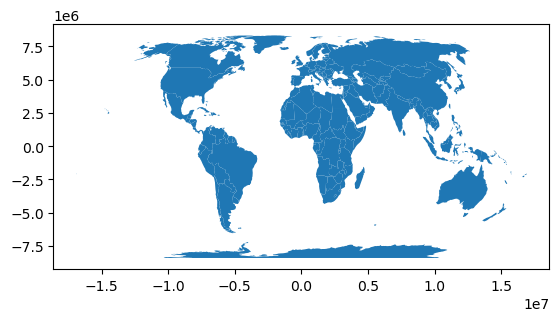

In [27]:
gdf = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
gdf.to_crs("EPSG:8857",inplace=True)

gdf.plot();

In [28]:
# Convert to dask-geopandas dataframe

dask_gdf = dask_geopandas.from_geopandas(gdf, npartitions=4)

If your dataset is too large to read into a regular GeoDataFrame efficiently, Dask-GeoPandas also supports [reading directly](https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.read_file.html) from a file.

Having a look at our `dask_gdf`, we can see the number of partitions (4), data types of all columns, and how many objects we have in each partition:

In [29]:
dask_gdf

Dask GeoDataFrame Structure:
               pop_est continent    name  iso_a3 gdp_md_est  geometry
npartitions=4                                                        
0              float64    object  object  object      int64  geometry
45                 ...       ...     ...     ...        ...       ...
89                 ...       ...     ...     ...        ...       ...
133                ...       ...     ...     ...        ...       ...
176                ...       ...     ...     ...        ...       ...
Dask Name: from_pandas, 1 graph layer

When we want to do a computation on a pandas/geopandas column, we simple run for example:

In [30]:
gdf.geometry.area

0      1.928532e+10
1      9.327289e+11
2      9.673516e+10
3      1.003399e+13
4      9.513249e+12
           ...     
172    7.637700e+10
173    1.344553e+10
174    1.123198e+10
175    7.741863e+09
176    6.248938e+11
Length: 177, dtype: float64

For Dask-GeoPandas, we need to add `compute()`:

In [31]:
# This does not actually compute the area (returns an empty result, since we haven't loaded the whole dataframe into memory)
dask_gdf.geometry.area

Dask Series Structure:
npartitions=4
0      float64
45         ...
89         ...
133        ...
176        ...
dtype: float64
Dask Name: area, 3 graph layers

In [32]:
dask_gdf.geometry.area.compute()

0      1.928532e+10
1      9.327289e+11
2      9.673516e+10
3      1.003399e+13
4      9.513249e+12
           ...     
172    7.637700e+10
173    1.344553e+10
174    1.123198e+10
175    7.741863e+09
176    6.248938e+11
Length: 177, dtype: float64

### Comparing performances with point-in-polygon

To see the benefits of using Dask-GeoPandas, let's do a quick point-in-polygon computation using random points:

In [33]:
N = 10_000_000 # You can decrease this number if it takes too long to run on your machine

points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(np.random.randn(N),np.random.randn(N)))

In [34]:
# Dask version
dpoints =  dask_geopandas.from_geopandas(points, npartitions=16)

A single polygon for which we will check if the points are located within this polygon:

In [35]:
box = shapely.geometry.box(0, 0, 1, 1)

**Let's first try to find the points within the box using the regular GeoDataFrame:**

In [36]:
%%time
points.within(box)

CPU times: user 1.35 s, sys: 125 ms, total: 1.48 s
Wall time: 1.5 s


0          False
1          False
2          False
3          False
4          False
           ...  
9999995    False
9999996    False
9999997    False
9999998    False
9999999    False
Length: 10000000, dtype: bool

**...and then with the Dask-GeoPandas dataframe:**

In [37]:
%%time

dpoints.within(box).compute()


CPU times: user 1.03 s, sys: 47.5 ms, total: 1.08 s
Wall time: 185 ms


0          False
1          False
2          False
3          False
4          False
           ...  
9999995    False
9999996    False
9999997    False
9999998    False
9999999    False
Length: 10000000, dtype: bool

In this case, using dask-geopandas is much faster.

### Speeding up spatial operations

To compare the computational time, let's first turn our area and tree data from earlier into Dask-GeoPandas dataframes:

In [38]:
dareas = dask_geopandas.from_geopandas(areas, npartitions=4)
dareas

Dask GeoDataFrame Structure:
              local_id voting_name municipal_id area_name ValgstedId  geometry
npartitions=4                                                                 
0               object      object       object    object      int64  geometry
337                ...         ...          ...       ...        ...       ...
674                ...         ...          ...       ...        ...       ...
1011               ...         ...          ...       ...        ...       ...
1346               ...         ...          ...       ...        ...       ...
Dask Name: from_pandas, 1 graph layer

In [39]:
dtrees = dask_geopandas.from_geopandas(trees, npartitions=6)
dtrees

Dask GeoDataFrame Structure:
              objectid  geometry
npartitions=6                   
0               object  geometry
253939             ...       ...
...                ...       ...
1269693            ...       ...
1523630            ...       ...
Dask Name: from_pandas, 1 graph layer

The "slow" type of spatial join from before can be done much faster with Dask - but Dask-Geopandas only supports "inner" joins at the moment...

**Using normal GeoDataFrames:**

In [40]:
%%time
trees.sjoin(areas[['geometry','ValgstedId']], predicate="intersects", how="inner")

CPU times: user 29.3 s, sys: 381 ms, total: 29.7 s
Wall time: 29.8 s


objectid  \
0        121680966620210914113041544   
1        121680966720210914113041544   
718      121680966820210914113041544   
728      121680966920210914113041544   
737      121680967020210914113041544   
...                              ...   
1385137  121980686420220120165212802   
1385138  121980686520220120165212802   
1385139  121980686620220120165212802   
1385140  121980686720220120165212802   
1385141  121980686820220120165212802   

                                             geometry  index_right  ValgstedId  
0        MULTIPOINT Z (712251.160 6186729.850 49.040)         1029      190001  
1        MULTIPOINT Z (711110.060 6187458.770 53.490)         1029      190001  
718      MULTIPOINT Z (711114.680 6187466.620 53.390)         1029      190001  
728      MULTIPOINT Z (711104.330 6187449.350 53.490)         1029      190001  
737      MULTIPOINT Z (711106.120 6187441.490 53.490)         1029      190001  
...                                               ...          ...         ...  
1385137  MULTIPOINT Z (528209.760 6194145.760 95.160)           79      766025  
1385138  MULTIPOINT Z (528268.020 6194095.970 95.480)           79      766025  
1385139  MULTIPOINT Z (528086.260 6194368.410 98.570)           79      766025  
1385140  MULTIPOINT Z (528087.910 6194364.710 98.570)           79      766025  
1385141  MULTIPOINT Z (528089.880 6194361.260 98.570)           79      766025  

[1523607 rows x 4 columns]

**Using Dask-GeoDataframes for both datasets:** 

(It might not save you CPU time, but the results will be ready sooner)

In [41]:
%%time
dtrees.sjoin(dareas[['geometry','ValgstedId']], predicate="intersects", how="inner").compute()

CPU times: user 51.9 s, sys: 651 ms, total: 52.5 s
Wall time: 6.22 s


objectid  \
795         102755577720160715091638   
796         102755591820160715091638   
797         102755608220160715091638   
798         102755608620160715091638   
799         102755613120160715091638   
...                              ...   
1514861  122303211320221123192840148   
1514862  122303211420221123192840148   
1514863  122303211520221123192840148   
1514864  122303211620221123192840148   
1514865  122303211720221123192840148   

                                             geometry  index_right  ValgstedId  
795      MULTIPOINT Z (568564.860 6216038.140 68.600)           89      751006  
796      MULTIPOINT Z (568560.190 6216026.770 68.370)           89      751006  
797      MULTIPOINT Z (569385.680 6216421.060 66.300)           89      751006  
798      MULTIPOINT Z (569322.140 6216448.110 66.160)           89      751006  
799      MULTIPOINT Z (568561.240 6216019.170 68.370)           89      751006  
...                                               ...          ...         ...  
1514861  MULTIPOINT Z (702452.020 6133087.670 20.590)         1319      320005  
1514862  MULTIPOINT Z (702445.690 6133078.870 20.810)         1319      320005  
1514863  MULTIPOINT Z (702443.160 6133066.340 20.960)         1319      320005  
1514864  MULTIPOINT Z (702426.010 6133050.110 21.170)         1319      320005  
1514865  MULTIPOINT Z (702395.300 6133027.480 21.940)         1319      320005  

[1523607 rows x 4 columns]

### Spatial partitioning

So far we have just used the regular partitioning offered by Dask-GeoPandas, which, from a spatial standpoint, is a random partitioning just splitting the dataframe by rows.

Dask-GeoPandas uses `spatial_shuffle` to partition the data based on the geographical dimension.

To see this in practice, we will use a dataset of the Contiguous United States.

In [42]:
usa = gpd.read_file("data/us_cont.gpkg")

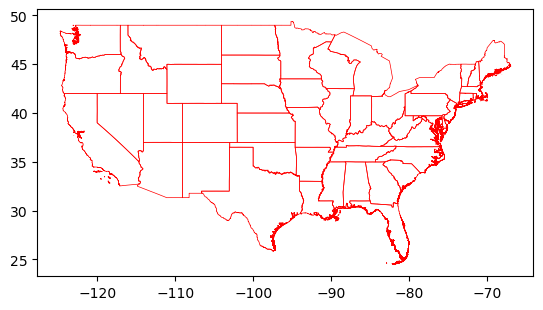

In [43]:
usa.plot(facecolor="none", linewidth=0.5, edgecolor="red");

Turn the GeoDataFrame into a Dask-GeoPandas dataframe (using regular partitioning):

In [44]:
d_usa = dask_geopandas.from_geopandas(usa, npartitions=4) #
d_usa

Dask GeoDataFrame Structure:
                State  geometry
npartitions=4                  
0              object  geometry
13                ...       ...
25                ...       ...
37                ...       ...
48                ...       ...
Dask Name: from_pandas, 1 graph layer

By visualising the convex hull of each partition, we can get a feel for how the Dask-GeoDataFrame has been partitioned. A useful spatial partitioning scheme is one that minimises the degree of spatial overlap between partitions. By default, the standard partitions does a poor job of spatially partitioning our example data - there is a high degree of overlap between partitions.

In [45]:
d_usa.calculate_spatial_partitions() # convex hull
d_usa.spatial_partitions

0    POLYGON ((-81.96430 24.52042, -82.87569 24.610...
1    POLYGON ((-89.42000 28.92833, -90.92028 29.048...
2    POLYGON ((-109.04997 31.33190, -114.63287 35.0...
3    POLYGON ((-97.40186 25.83808, -97.40523 25.838...
dtype: geometry

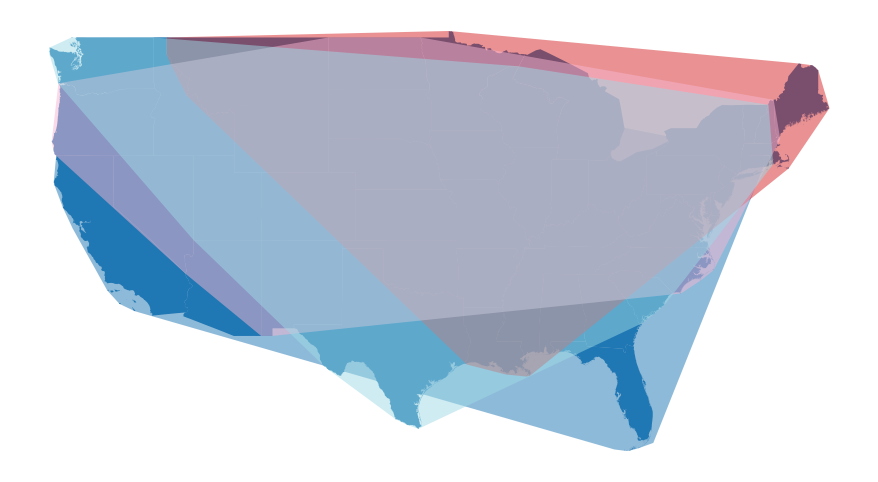

In [46]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
usa.plot(ax=ax)
d_usa.spatial_partitions.plot(ax=ax, cmap="tab20", alpha=0.5)
ax.set_axis_off()
plt.show()

We can reduce the spatially overlapping partitions by using `spatial_shuffle()`.

Dask-GeoPandas supports [3 different methods](https://dask-geopandas.readthedocs.io/en/stable/guide/spatial-partitioning.html):

In [47]:
hilbert = d_usa.spatial_shuffle(by="hilbert")
morton = d_usa.spatial_shuffle(by="morton")
geohash = d_usa.spatial_shuffle(by="geohash")

None of them completely removes the spatial overlap, but they all reduce it:

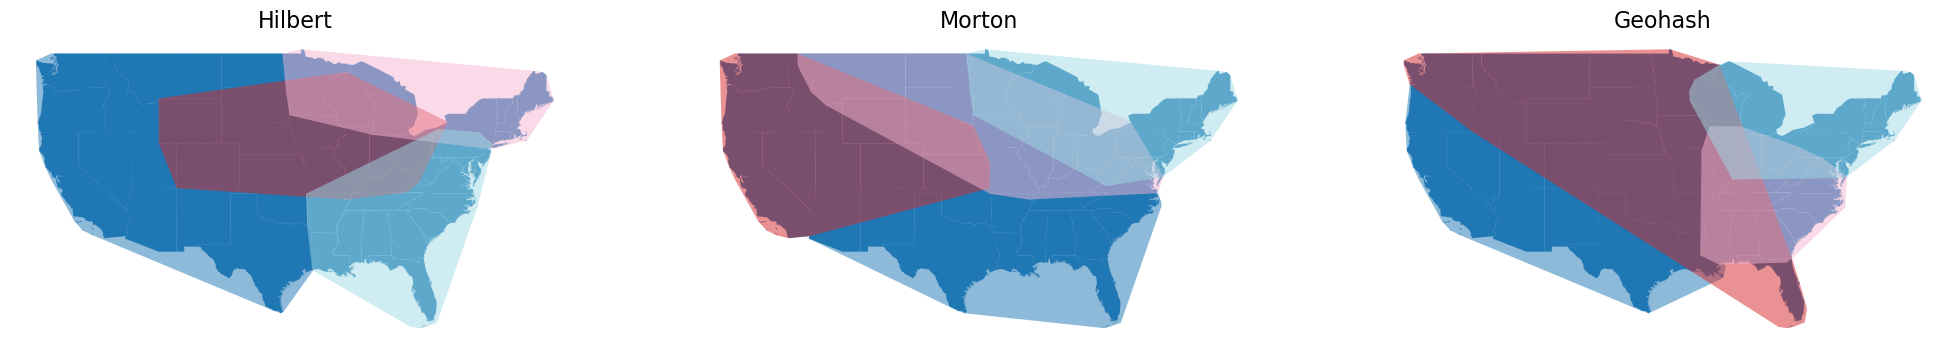

In [48]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(25,12))
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    usa.plot(ax=ax)

hilbert.spatial_partitions.plot(ax=ax1, cmap="tab20", alpha=0.5)
morton.spatial_partitions.plot(ax=ax2, cmap="tab20", alpha=0.5)
geohash.spatial_partitions.plot(ax=ax3, cmap="tab20", alpha=0.5)

[axi.set_axis_off() for axi in axes.ravel()]

ax1.set_title("Hilbert", size=16)
ax2.set_title("Morton", size=16)
ax3.set_title("Geohash", size=16)

plt.show()

**Changing the number of partitions**

We can change the number of partitions when doing the spatial shuffling. If no number of partitions is specified when using `spatial_shuffle`, the outcome will have as many partitions as the original Dask-GeoPandas dataframe.

The ideal number of partitions depends on your data structure and how you plan to use your data.

In [49]:
hilbert20 = d_usa.spatial_shuffle(by="hilbert", npartitions=20)

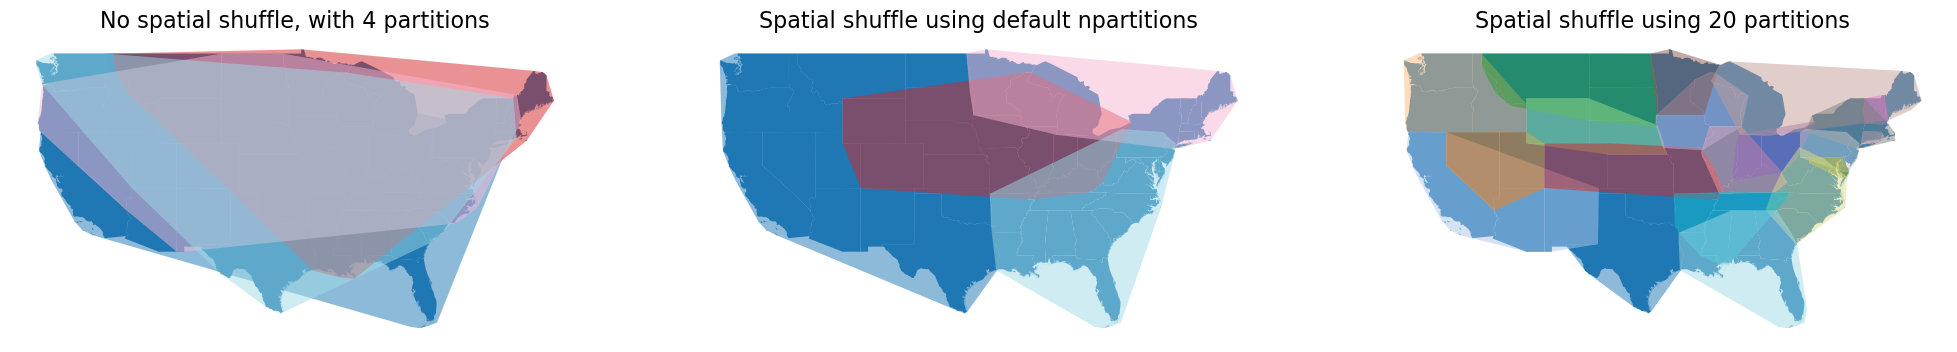

In [50]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(25,12))
ax1, ax2, ax3 = axes.flatten()

for ax in axes:
    usa.plot(ax=ax)

d_usa.spatial_partitions.plot(ax=ax1, cmap="tab20", alpha=0.5)
hilbert.spatial_partitions.plot(ax=ax2, cmap="tab20", alpha=0.5)
hilbert20.spatial_partitions.plot(ax=ax3, cmap="tab20", alpha=0.5)

[axi.set_axis_off() for axi in axes.ravel()]

ax1.set_title("No spatial shuffle, with 4 partitions", size=16)
ax2.set_title("Spatial shuffle using default npartitions", size=16)
ax3.set_title("Spatial shuffle using 20 partitions", size=16)

plt.show()

**Why spatial partitioning?**

If you are querying for a small spatial subset of your data, using spatial partitioning means than we can ignore the data in the other partitions. At the moment, it is still an [open issue](https://notebooksharing.space/view/88055f29ae1c26b22f61a1ef5f673cf971f434f2e513933d8de2001d7f49162a#displayOptions=) to make Dask-GeoPandas default utilizing spatial partitioning to improve spatial operations. Spatial partitioning can however be used to only load the data into memory that you need - see below.

### Exporting Dask-Geopandas

Dask-GeoPandas only supports writing files to `feather` and `parquet`. This will export each partition to its own file.

In [51]:
dask_gdf.to_parquet("data/dask_export.parquet")

In [52]:
ddf = dask_geopandas.read_parquet("data/dask_export.parquet", gather_spatial_partitions=False)
ddf.spatial_partitions  # None

**Exporting and reading a spatially partitioned dataset:**

Whenever we save a partitioned dataset we have the option of only reading part of the partitions. If we have used spatial partitioning we can make use of this to only include data for the area we are interested in.

In [53]:
# Save spatially partitioned data
geohash.to_parquet("data/geohash.parquet")

In [54]:
# read only the first partition
part0 = dask_geopandas.read_parquet("data/geohash.parquet/part.0.parquet")

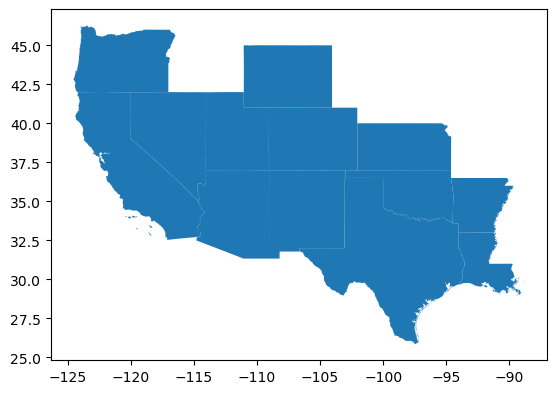

In [55]:
# Plot data to see what the first partition includes
part0.head(len(part0)).plot();

If we don't know beforehand which spatial partition we are interested in, we can read the whole file and query the spatial partitioning.
Dask-GeoPandas can return the extent of the spatial partitions without reading the entire dataset into memory. Once you know which partition you are interested in, you can limit the rest of the analysis to that partition alone.

Imagine you have a *very* big dataset with US data and only want to load the partition that contains the location of New York:

* First, we 'read' the whole parquet file. This loads the meta data without reading the entire file into memory:

In [56]:
geohash_from_parquet = dask_geopandas.read_parquet("data/geohash.parquet/")

geohash_from_parquet.spatial_partitions

0    POLYGON ((-88.81814 25.83808, -88.81814 46.292...
1    POLYGON ((-79.72264 24.52042, -79.72264 49.383...
2    POLYGON ((-75.24252 30.17444, -75.24252 42.509...
3    POLYGON ((-66.94889 37.77305, -66.94889 48.304...
dtype: geometry

* Then, we use the polygons for the spatial partitions to check which contain the location of NY. Note that the partitions can be overlapping, so it might be more than one:

In [57]:
from shapely.geometry import Point
ny_coords = Point(-74.0059413,40.7127837)

In [58]:
for i, polygon in geohash_from_parquet.spatial_partitions.items():
   if polygon.intersects(ny_coords):
      print(f"New York is in partition {i}")

New York is in partition 3


Now we know that we only have to work with partition 3 (this small example only uses a point to represent the location of New York. To get an accurate result, we would of course need to use a polygon showing the true extent of the city).


## H3

<img src="files/h3.png" alt="H3 logo" width="150"/>

H3 is both a useful tool for spatial indexing, aggregation, and spatial queries and supports some type of analysis, such as surface interpolation, clustering etc.

**Useful links:**

* [Official H3 website](https://h3geo.org/)
* [h3-py](https://uber.github.io/h3-py/intro.html)
* [Example notebooks](https://github.com/uber/h3-py-notebooks)
* A few other examples of using H3 in geospatial analysis:
    * https://towardsdatascience.com/geographic-clustering-with-hdbscan-ef8cb0ed6051
    * https://towardsdatascience.com/uber-h3-for-data-analysis-with-python-1e54acdcc908
    * https://betterprogramming.pub/playing-with-ubers-hexagonal-hierarchical-spatial-index-h3-ed8d5cd7739d 


We use the H3-py library from Uber here, but see also [H3-Pandas](https://h3-pandas.readthedocs.io/en/latest/index.html).

In [59]:
import h3
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from rasterio.plot import show
import rioxarray as rxr
import contextily as cx 

### Vectorizing raster data with H3

One great use case of H3 hexagons is fast conversion of raster/image data to vector format.
In this example we will use a raster with population densities downloaded from the [Global Human Settlement](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop) database.

The raster has been preprocessed to make sure that we have one coherent raster for all of Denmark, and that it is in a CRS compatible with H3 (WGS84).

In [60]:
# Small helper function for plotting

def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):   

    '''
    Helper function from H3 tutorials: https://github.com/uber/h3-py-notebooks
    ''' 
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

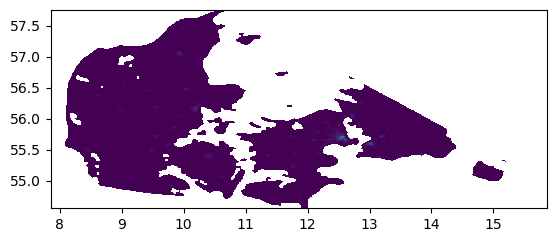

In [61]:
# load pop raster and plot
pop_raster = rasterio.open("data/reproj_pop_raster_wgs84.tif")

show(pop_raster);

First, we use a xarray meethod `to_pandas()` to convert our raster data to a vector point dataset. This is called *vectorization*.

In [62]:
# Convert raster to pandas dataframe with coordinates and pop values

pop_df = (
    rxr.open_rasterio("data/reproj_pop_raster_wgs84.tif")
    .sel(band=1)
    .to_pandas()
    .stack()
    .reset_index()
    .rename(columns={"x": "lng", "y": "lat", 0: "population"})
)

pop_df

lat        lng  population
0        57.755573   7.855634      -200.0
1        57.755573   7.860599      -200.0
2        57.755573   7.865563      -200.0
3        57.755573   7.870527      -200.0
4        57.755573   7.875491      -200.0
...            ...        ...         ...
1040380  54.558575  15.838199      -200.0
1040381  54.558575  15.843163      -200.0
1040382  54.558575  15.848127      -200.0
1040383  54.558575  15.853092      -200.0
1040384  54.558575  15.858056      -200.0

[1040385 rows x 3 columns]

A bit of processing of our pandas data + turn it into a GeoDataFrame:

In [63]:
# Ignore no data values
pop_df = pop_df[pop_df.population > -200]

# Convert to GeoDataFrame
pop_gdf = gpd.GeoDataFrame(pop_df, geometry=gpd.points_from_xy(pop_df.lng, pop_df.lat))

# Define CRS
pop_gdf.set_crs("EPSG:4326", inplace=True)


lat        lng  population                   geometry
548      57.755573  10.576060    0.000000  POINT (10.57606 57.75557)
549      57.755573  10.581025    0.000000  POINT (10.58102 57.75557)
550      57.755573  10.585989    0.000000  POINT (10.58599 57.75557)
551      57.755573  10.590953    0.000090  POINT (10.59095 57.75557)
552      57.755573  10.595918    0.000225  POINT (10.59592 57.75557)
...            ...        ...         ...                        ...
1039606  54.558575  11.995845    0.000000  POINT (11.99584 54.55858)
1039607  54.558575  12.000809    0.000000  POINT (12.00081 54.55858)
1039608  54.558575  12.005774    0.000000  POINT (12.00577 54.55858)
1039609  54.558575  12.010738    0.000000  POINT (12.01074 54.55858)
1039610  54.558575  12.015702    0.000000  POINT (12.01570 54.55858)

[390962 rows x 4 columns]

As we saw when we plotted the raster, we also have some data for Sweden. To make sure our final dataset only covers Denmark, let's use our `areas` data to cut the population data to the right extent.

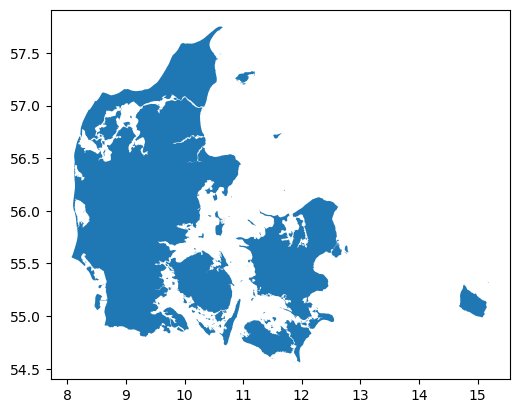

In [64]:
# Dissolve to one big geometry and project to same crs as pop data

dk_gdf = areas.dissolve().to_crs("EPSG:4326")

dk_gdf.plot();

Doing a spatial join with `sjoin` and `predicate="inner"` gives us a GeoDataFrame only with geometries where the two input datasets overlap:

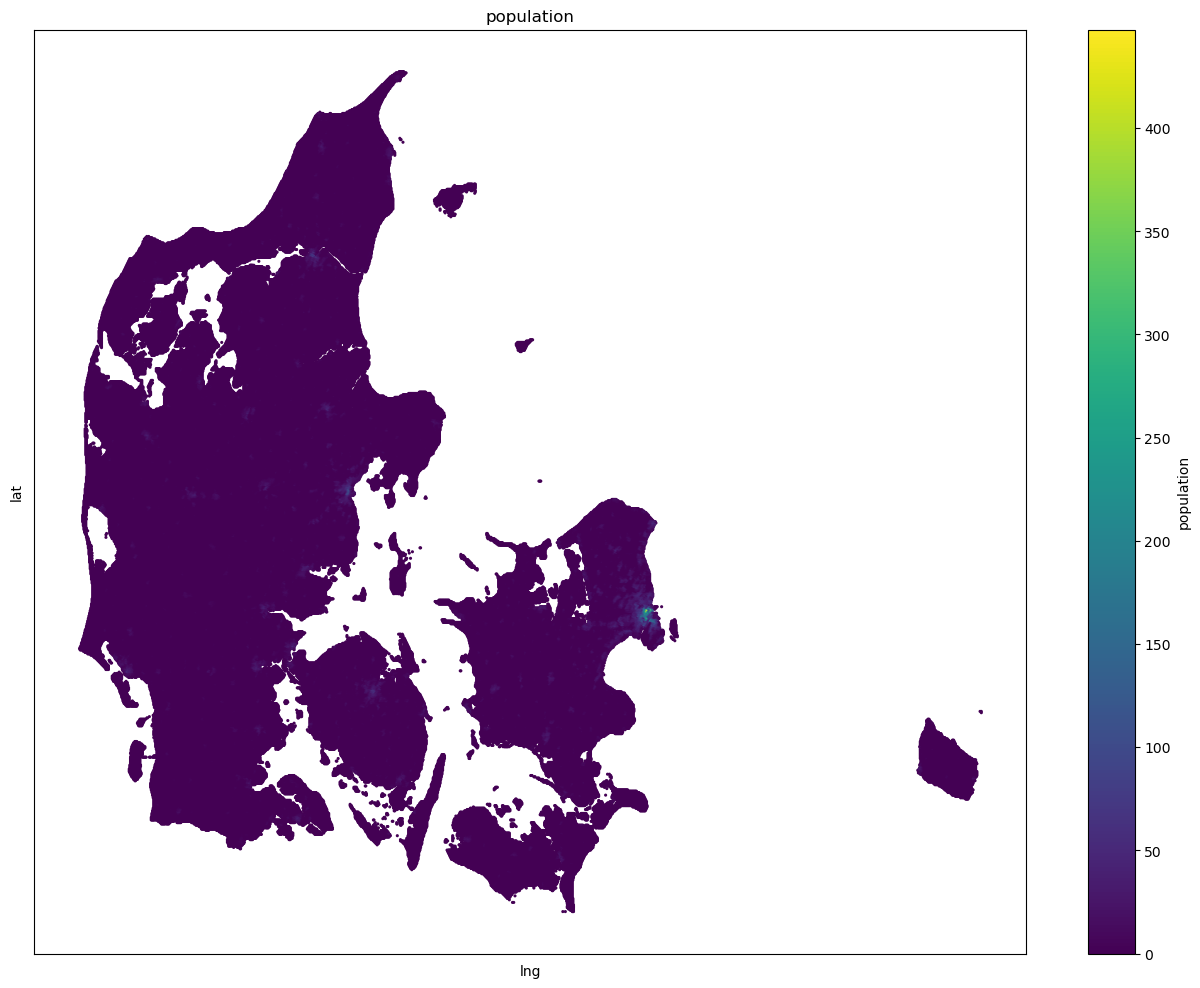

In [65]:
# Inner spatial join of pop points and DK boundary

joined_gdf = gpd.sjoin(pop_gdf, dk_gdf, predicate="within", how="inner")

plot_scatter(joined_gdf, metric_col="population", marker=".", colormap="viridis")

We have now turned our population raster into a population point dataset. However, if we want to combine our population data with other layers, you will often want to aggregate - for example with H3.

You can see the average sizes of the H3 hexagons [here](https://h3geo.org/docs/core-library/restable/).

Below we use the H3 method `geo_to_h3` to return the H3 index based on a point coordinate and a specificed H3 resolution.
We also use `h3_geo_to_boundary` which returns the hex polygon associated with a hex id as GeoJSON.

In [66]:
# INDEX POPULATION AT VARIOUS H3 LEVELS
for res in range(6, 9):
    col_hex_id = "hex_id_{}".format(res)
    col_geom = "geometry_{}".format(res)
    msg_ = "At resolution {} -->  H3 cell id : {}"
    print(msg_.format(res, col_hex_id, col_geom))

    joined_gdf[col_hex_id] = joined_gdf.apply(
        lambda row: h3.geo_to_h3(lat=row["lat"], lng=row["lng"], resolution=res), axis=1
    )
   

At resolution 6 -->  H3 cell id : hex_id_6
At resolution 7 -->  H3 cell id : hex_id_7
At resolution 8 -->  H3 cell id : hex_id_8


Now we have the id of the H3 hexagons for each data point at resolution 6 to 8:

In [67]:
joined_gdf.head()

lat        lng  population                   geometry  \
2165  57.750608  10.595918    0.002980  POINT (10.59592 57.75061)   
2166  57.750608  10.600882    0.001166  POINT (10.60088 57.75061)   
2167  57.750608  10.605846    0.000000  POINT (10.60585 57.75061)   
2168  57.750608  10.610810    0.000000  POINT (10.61081 57.75061)   
2169  57.750608  10.615775    0.000000  POINT (10.61577 57.75061)   

      index_right local_id                voting_name municipal_id area_name  \
2165            0       17  Hammerum-Gjellerup Hall'n         0657  Hammerum   
2166            0       17  Hammerum-Gjellerup Hall'n         0657  Hammerum   
2167            0       17  Hammerum-Gjellerup Hall'n         0657  Hammerum   
2168            0       17  Hammerum-Gjellerup Hall'n         0657  Hammerum   
2169            0       17  Hammerum-Gjellerup Hall'n         0657  Hammerum   

      ValgstedId         hex_id_6         hex_id_7         hex_id_8  
2165      657017  861f24a4fffffff  871f24a4effffff  881f24a4ebfffff  
2166      657017  861f24a4fffffff  871f24a4effffff  881f24a48dfffff  
2167      657017  861f24a4fffffff  871f24a48ffffff  881f24a48dfffff  
2168      657017  861f24a4fffffff  871f24a48ffffff  881f24a48dfffff  
2169      657017  861f24a4fffffff  871f24a48ffffff  881f24a481fffff

There are however many data points in each hex, so get get a correct aggregation, we need to summarize the number of people in each hex cell:

In [68]:
hex_id_col = "hex_id_7"
h3_groups = (
    joined_gdf.groupby(hex_id_col)["population"].sum().to_frame("population").reset_index()
)

# Get the coordinate of the centroid of the hexagons
h3_groups["lat"] = h3_groups[hex_id_col].apply(lambda x: h3.h3_to_geo(x)[0])
h3_groups["lng"] = h3_groups[hex_id_col].apply(lambda x: h3.h3_to_geo(x)[1])

# use h3.h3_to_geo_boundary to obtain the geometries of these hexagons
h3_groups["hex_geometry"] = h3_groups[hex_id_col].apply(
    lambda x: {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=x, geo_json=True)],
    }
)

In [69]:
h3_groups.head()

hex_id_7  population        lat       lng  \
0  87099269bffffff    0.000373  56.291590  8.112269   
1  8709926c1ffffff    0.000535  56.435820  8.105423   
2  8709926c2ffffff    0.000193  56.404224  8.111009   
3  8709926c3ffffff    0.000000  56.421921  8.126502   
4  8709926c8ffffff    2.724918  56.457298  8.157518   

                                        hex_geometry  
0  {'type': 'Polygon', 'coordinates': [((8.093097...  
1  {'type': 'Polygon', 'coordinates': [((8.086204...  
2  {'type': 'Polygon', 'coordinates': [((8.091800...  
3  {'type': 'Polygon', 'coordinates': [((8.107286...  
4  {'type': 'Polygon', 'coordinates': [((8.138289...

The hex geometries are still just stored as GeoJSON in a column, while the geometry column uses the centroid of the hex grids at our chosen resolution. If we plot we can see that it is just the centroids:

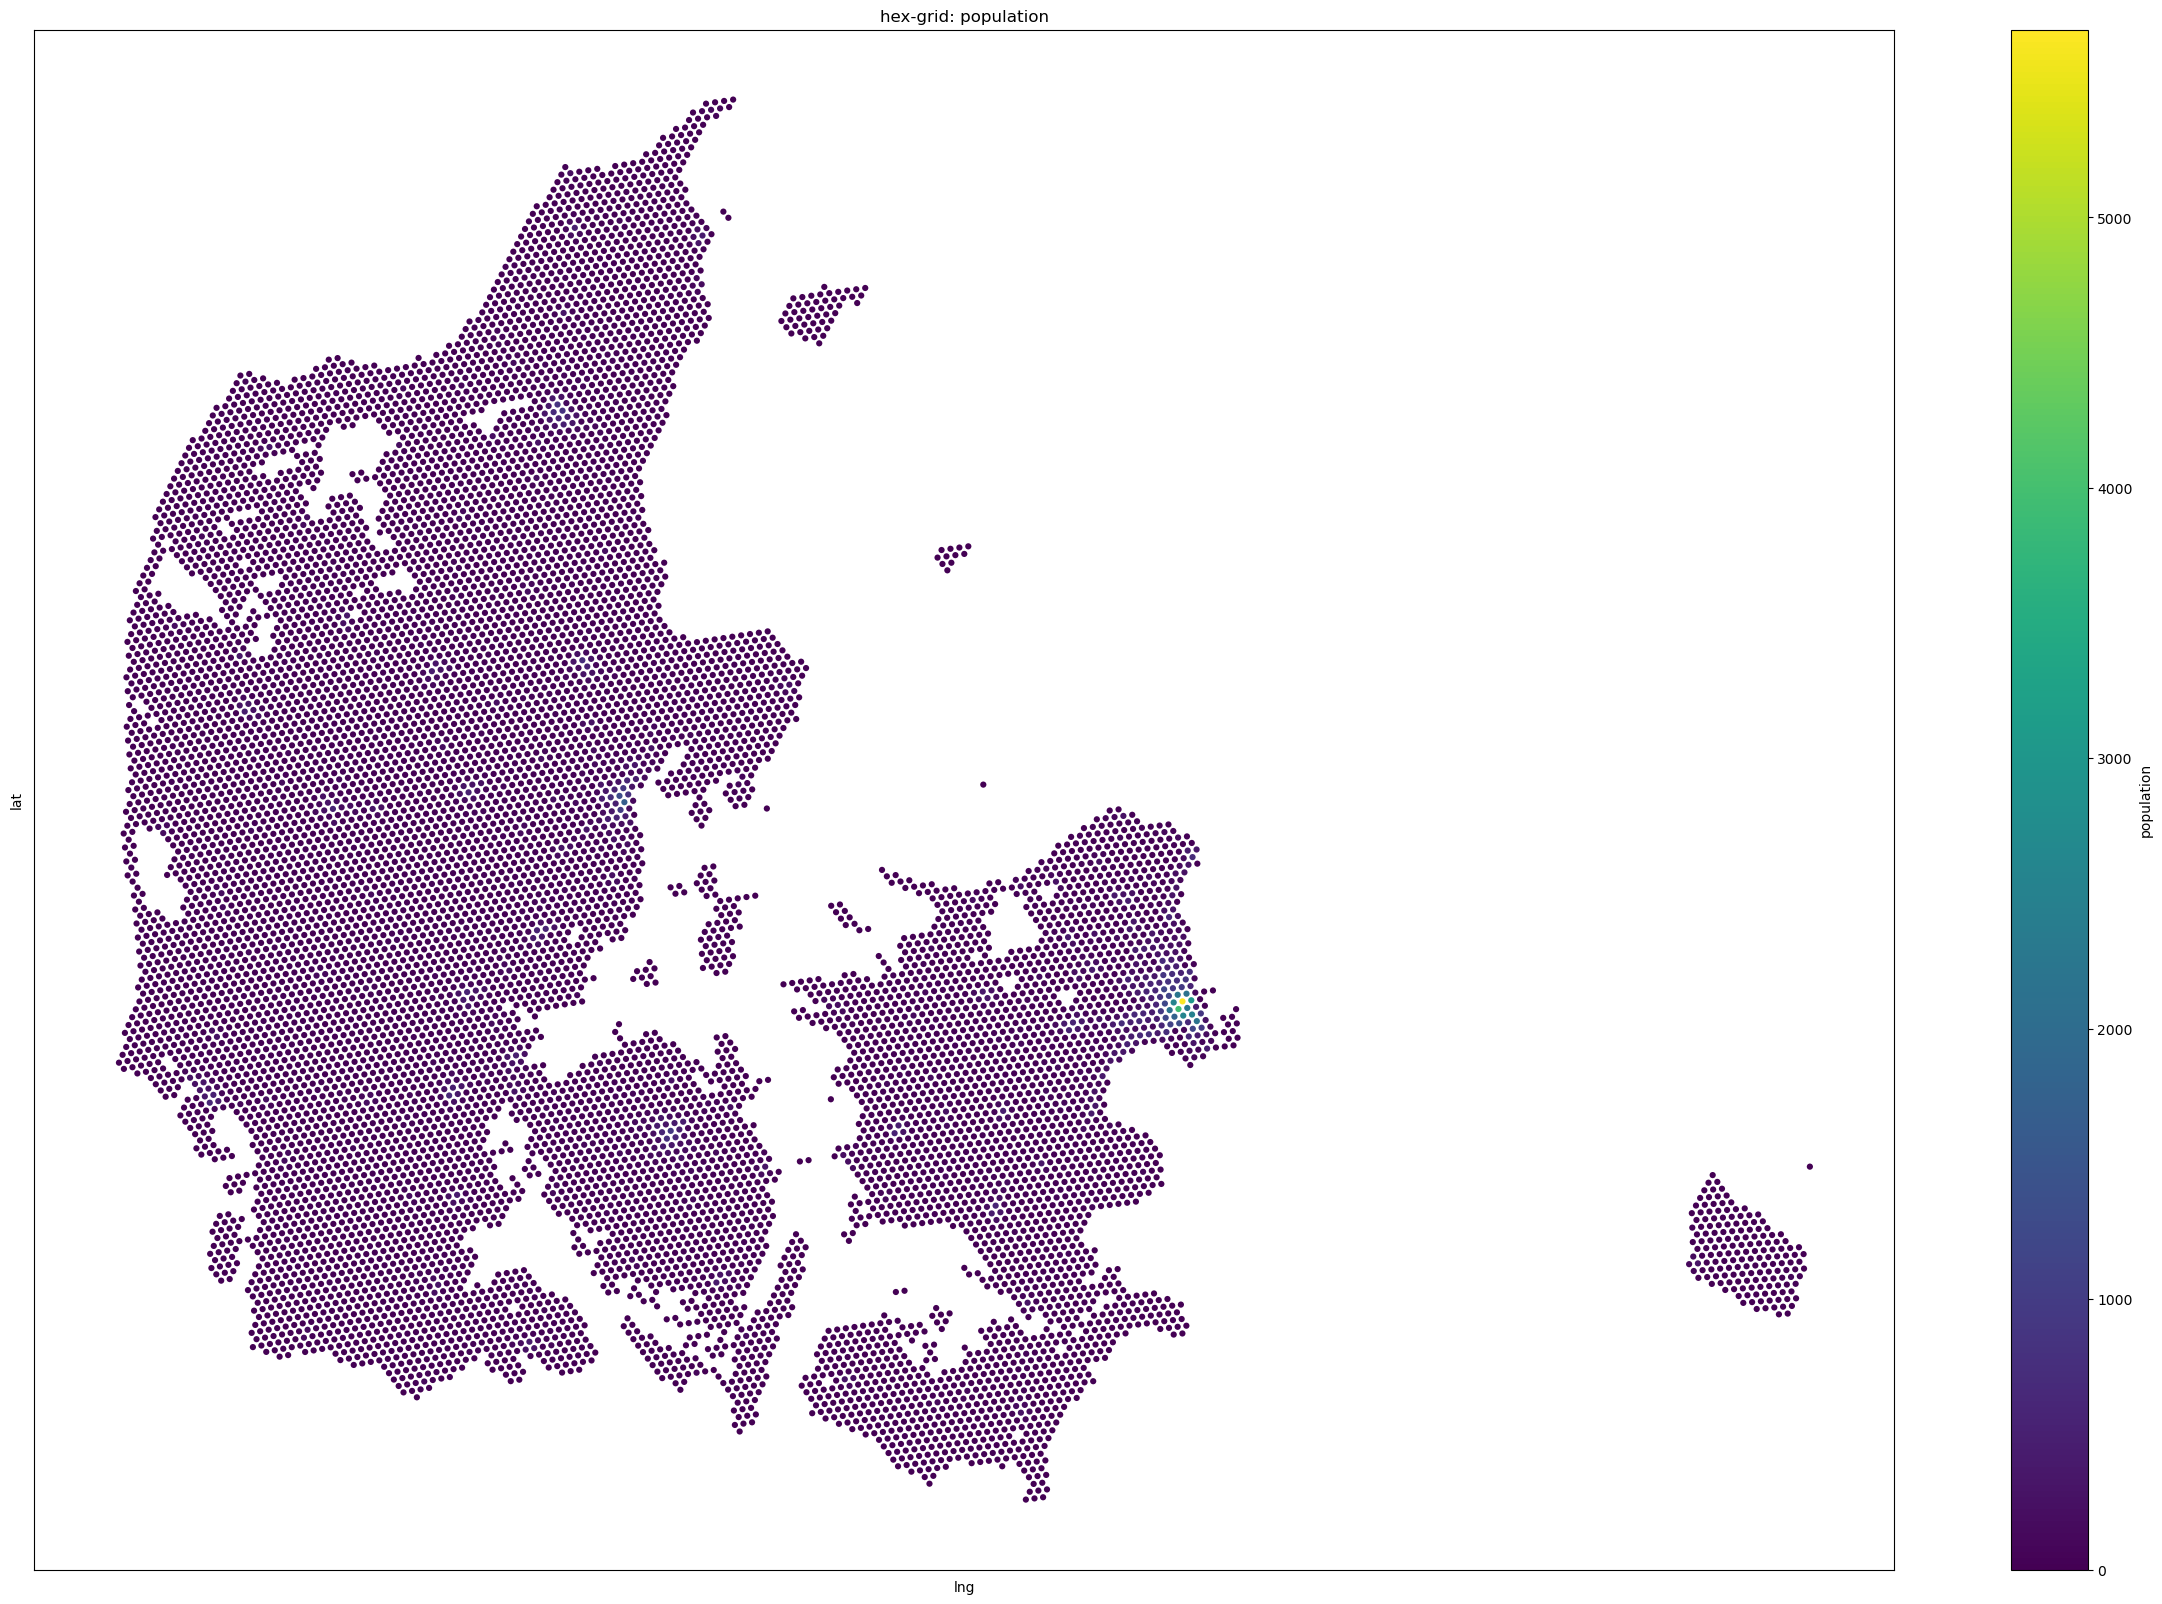

In [70]:
h3_groups.plot.scatter(
    x="lng",
    y="lat",
    c="population",
    marker="o",
    edgecolors="none",
    colormap="viridis",
    figsize=(30, 20),
)
plt.xticks([], [])
plt.yticks([], [])
plt.title("hex-grid: population");

Therefore, the final step is to use the H3 hexagon as the geometries:

In [71]:
h3_groups["geometry"] = h3_groups["hex_geometry"].apply(
    lambda x: Polygon(list(x["coordinates"][0]))
)

h3_gdf = gpd.GeoDataFrame(h3_groups, geometry="geometry", crs="EPSG:4326")


...and to see the final results:

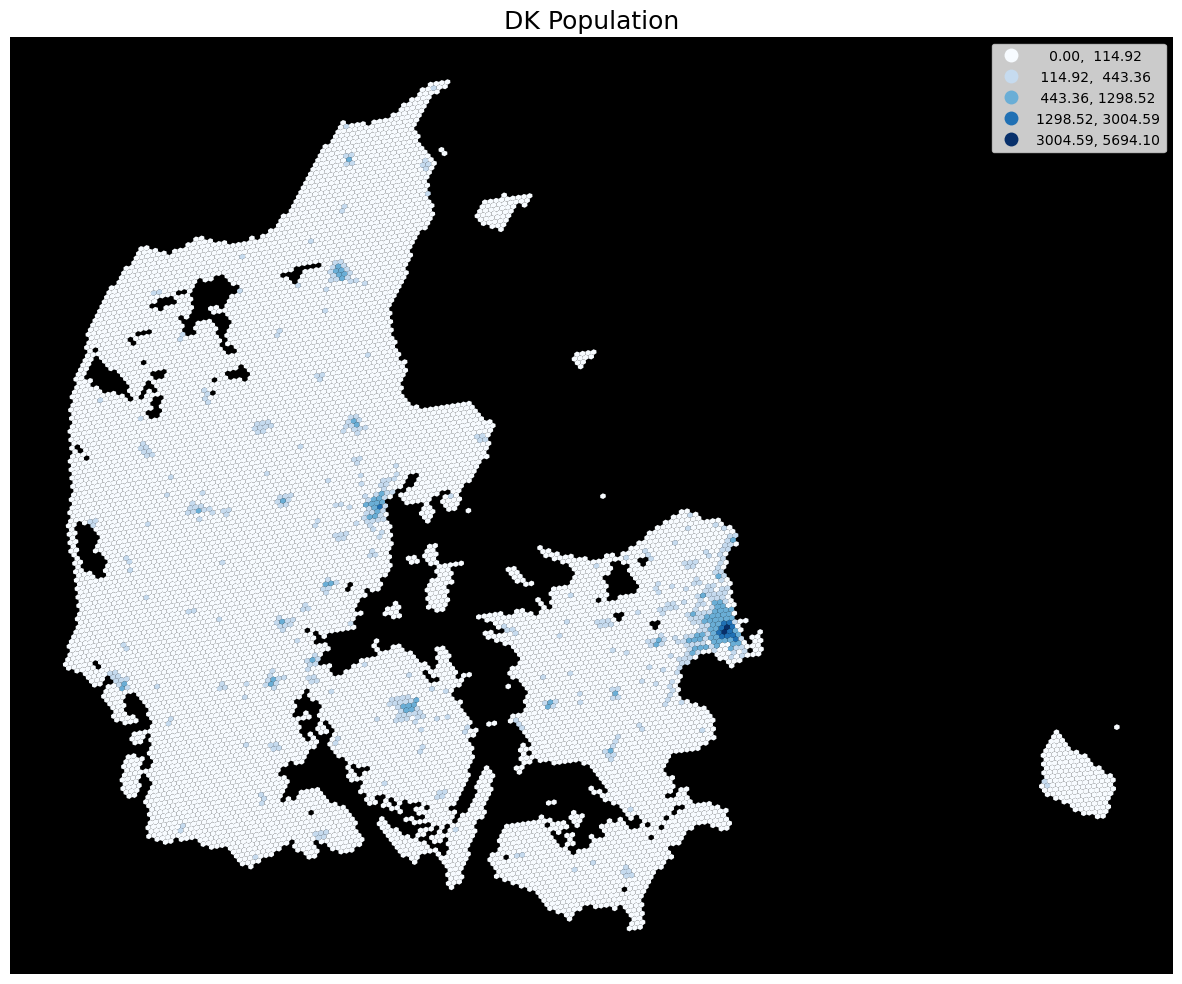

In [72]:
fig, ax = plt.subplots(figsize=(15,15))

ax.set_facecolor("black")

# Turn ax ticks off without affecting face color
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

h3_gdf.plot(ax=ax,column='population', scheme='fisherjenks', cmap='Blues', legend=True)

plt.title("DK Population",fontsize=18);

### Data aggregation of global shipping data

We can use a similar approach to aggregating this global data set on maritime piracy:

(Data from [Maritime Safety Information](https://msi.nga.mil/NGAPortal/MSI.porta), tutorial from [Spatial Thoughts](https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/)).

In [73]:
zipfile = 'zip://data/ASAM_shp.zip/asam_data_download/ASAM_events.shp'
incidents = gpd.read_file(zipfile)
incidents.head()

reference   dateofocc subreg                            hostility_  \
0    1990-9  1990-06-03     26                         CUBAN GUNBOAT   
1   1990-10  1990-03-20     71                               PIRATES   
2   1990-11  1990-03-20     61                               PIRATES   
3   1989-16  1989-01-01     62  PEOPLES DEMOCRATIC REPUBLIC OF YEMEN   
4   1989-17  1989-09-23     63                               PIRATES   

                 victim_d                                         descriptio  \
0          BELESBAT QUEEN  A CUBAN GUNBOAT COMMANDEERED LUXURY YACHT BELE...   
1        RO/RO SEA DRAGON  20 MARCH 1990. BORNEO.                        ...   
2           RO/RO SUNRISE  20 MARCH 1990. SINGAPORE.                     ...   
3           U.S. MARINERS  RED SEA, YEMEN                                ...   
4  LASH STONEWALL JACKSON  Indian ocean                                  ...   

   hostilityt        hostilit_D  victim_l  victim_l_D navarea  \
0           2  Naval Engagement        11      Vessel      IV   
1           1    Pirate Assault         3  Cargo Ship      XI   
2           1    Pirate Assault         3  Cargo Ship    VIII   
3           2  Naval Engagement        13       Other      IX   
4           1    Pirate Assault        11      Vessel    VIII   

                     geometry  
0  POINT (-75.13333 21.93333)  
1   POINT (108.00000 3.00000)  
2   POINT (90.00000 -1.00000)  
3   POINT (42.00000 14.00000)  
4   POINT (80.30000 13.10000)

This time, we use resolution 3 (so much bigger hexagons) for the data aggregation.

A small helper function helps us get the hex grid id corresponding to our point geometries: Notice the new column 'h3' after running the following cell:

In [74]:
h3_level = 3

def lat_lng_to_h3(row):
    return h3.geo_to_h3(row.geometry.y, row.geometry.x, h3_level)

incidents['h3'] = incidents.apply(lat_lng_to_h3, axis=1)
incidents.head()

reference   dateofocc subreg                            hostility_  \
0    1990-9  1990-06-03     26                         CUBAN GUNBOAT   
1   1990-10  1990-03-20     71                               PIRATES   
2   1990-11  1990-03-20     61                               PIRATES   
3   1989-16  1989-01-01     62  PEOPLES DEMOCRATIC REPUBLIC OF YEMEN   
4   1989-17  1989-09-23     63                               PIRATES   

                 victim_d                                         descriptio  \
0          BELESBAT QUEEN  A CUBAN GUNBOAT COMMANDEERED LUXURY YACHT BELE...   
1        RO/RO SEA DRAGON  20 MARCH 1990. BORNEO.                        ...   
2           RO/RO SUNRISE  20 MARCH 1990. SINGAPORE.                     ...   
3           U.S. MARINERS  RED SEA, YEMEN                                ...   
4  LASH STONEWALL JACKSON  Indian ocean                                  ...   

   hostilityt        hostilit_D  victim_l  victim_l_D navarea  \
0           2  Naval Engagement        11      Vessel      IV   
1           1    Pirate Assault         3  Cargo Ship      XI   
2           1    Pirate Assault         3  Cargo Ship    VIII   
3           2  Naval Engagement        13       Other      IX   
4           1    Pirate Assault        11      Vessel    VIII   

                     geometry               h3  
0  POINT (-75.13333 21.93333)  834c91fffffffff  
1   POINT (108.00000 3.00000)  836990fffffffff  
2   POINT (90.00000 -1.00000)  8386b4fffffffff  
3   POINT (42.00000 14.00000)  8352a9fffffffff  
4   POINT (80.30000 13.10000)  83618efffffffff

In the population example we took the sum of all population points in each hex grid. In this case each point represents one incident, so we use count to aggregate:

In [75]:
counts = incidents.groupby(['h3']).h3.agg('count').to_frame('count').reset_index()
counts.sample(5)

h3  count
1142  837b9efffffffff      3
87    83396efffffffff      1
750   836615fffffffff      1
1323  838cd3fffffffff      1
1298  838c95fffffffff      2

Just like in the first example, we want to get the polygons corresponding to the hex grid ids:

In [76]:
def add_geometry(row):
    points = h3.h3_to_geo_boundary(row['h3'], True)
    return Polygon(points)

counts['geometry'] = counts.apply(add_geometry, axis=1)
counts.head()

h3  count                                           geometry
0  83099bfffffffff      1  POLYGON ((10.43240686106979 59.303038927310276...
1  83182afffffffff      1  POLYGON ((-8.90683921786222 52.694400353462534...
2  831864fffffffff      1  POLYGON ((-0.6310947579755037 50.6019111204840...
3  831865fffffffff      1  POLYGON ((0.3608556306599041 49.73574240198919...
4  831873fffffffff      1  POLYGON ((-5.874786713992012 49.23891353771817...

Finally, we turn it into a GeoDataFrame and specify the CRS:

In [77]:
gdf = gpd.GeoDataFrame(counts, crs='EPSG:4326')

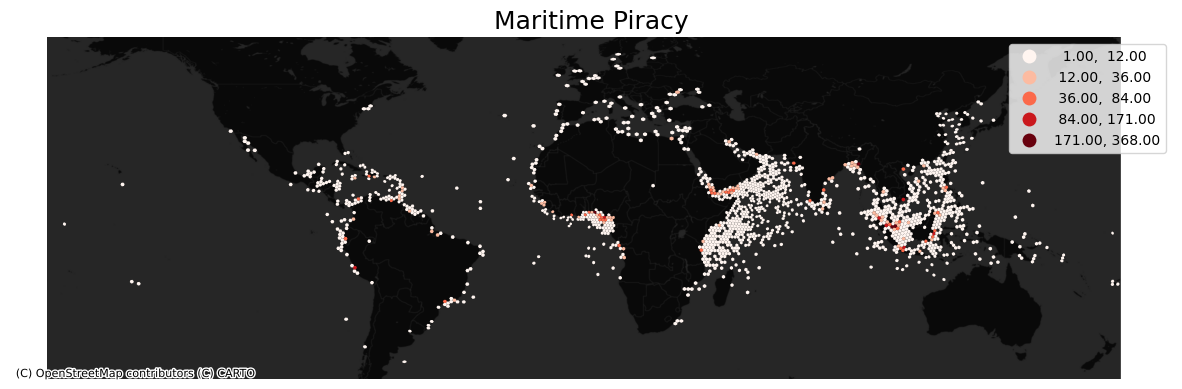

In [78]:
fig, ax = plt.subplots(figsize=(15,15))

ax.set_axis_off()

gdf.plot(ax=ax,column='count', scheme='fisherjenks',  cmap='Reds', legend=True)
cx.add_basemap(ax=ax, crs=gdf.crs, source=cx.providers.CartoDB.DarkMatterNoLabels)

plt.title("Maritime Piracy",fontsize=18);